In [1]:
!pwd

/content


In [2]:
cd /content/drive/MyDrive/SOS/DRIVE_Data/UNET

/content/drive/MyDrive/SOS/DRIVE_Data/UNET


In [ ]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import imageio
from albumentations import HorizontalFlip, VerticalFlip, Rotate

In [ ]:
def load_data(path):
    train_x = sorted(glob(os.path.join(path, "training", "images", "*.tif")))
    train_y = sorted(glob(os.path.join(path, "training", "1st_manual", "*.gif")))

    test_x = sorted(glob(os.path.join(path, "test", "images", "*.tif")))
    test_y = sorted(glob(os.path.join(path, "test", "Manual_2", "*.jpg")))

    return (train_x, train_y), (test_x, test_y)

In [ ]:
if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)

    """ Load the data """
    data_path = "/content/drive/MyDrive/SOS/DRIVE_Data/UNET/"
    (train_x, train_y), (test_x, test_y) = load_data(data_path)

In [ ]:
print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Test: {len(test_x)} - {len(test_y)}")

Train: 20 - 20
Test: 20 - 20


In [ ]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
    """ Create directories to save the augmented data """
    create_dir("new_data/train/image/")
    create_dir("new_data/train/mask/")
    create_dir("new_data/test/image/")
    create_dir("new_data/test/mask/")

In [ ]:
def augment_data(images, masks, save_path, augment=True):
    size = (512, 512)
    for idx, (x, y) in tqdm(enumerate(zip(images, masks)), total=len(images)):
        """ Extracting the name """
        name = x.split("/")[-1].split(".")[0]

        """ Reading image and mask """
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = imageio.mimread(y)[0]

        if augment == True:
            aug = HorizontalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x1 = augmented["image"]
            y1 = augmented["mask"]

            aug = VerticalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x2 = augmented["image"]
            y2 = augmented["mask"]

            aug = Rotate(limit=45, p=1.0)
            augmented = aug(image=x, mask=y)
            x3 = augmented["image"]
            y3 = augmented["mask"]

            X = [x, x1, x2, x3]
            Y = [y, y1, y2, y3]

        else:
            X = [x]
            Y = [y]

        index = 0
        for i, m in zip(X, Y):
            i = cv2.resize(i, size)
            m = cv2.resize(m, size)

            tmp_image_name = f"{name}_{index}.png"
            tmp_mask_name = f"{name}_{index}.png"

            image_path = os.path.join(save_path, "image", tmp_image_name)
            mask_path = os.path.join(save_path, "mask", tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            index += 1

In [ ]:
    augment_data(train_x, train_y, "new_data/train/", augment=True)
    augment_data(test_x, test_y, "new_data/test/", augment=False)

100%|██████████| 20/20 [00:38<00:00,  1.93s/it]


#**Training on the augmented dataset**

In [5]:

import os
import time
from glob import glob

import torch
from torch.utils.data import DataLoader
import torch.nn as nn

from data import DriveDataset
from model import build_unet
from loss import DiceLoss, DiceBCELoss
from utils import seeding, create_dir, epoch_time

def train(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0

    model.train()
    for x, y in loader:
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

        epoch_loss = epoch_loss/len(loader)
    return epoch_loss

if __name__ == "__main__":
    """ Seeding """
    seeding(42)

    """ Directories """
    # create_dir("files")

    """ Load dataset """
    train_x = sorted(glob("/content/drive/MyDrive/SOS/DRIVE_Data/UNET/new_data/train/image/*"))
    train_y = sorted(glob("/content/drive/MyDrive/SOS/DRIVE_Data/UNET/new_data/train/mask/*"))

    valid_x = sorted(glob("/content/drive/MyDrive/SOS/DRIVE_Data/UNET/new_data/test/image/*"))
    valid_y = sorted(glob("/content/drive/MyDrive/SOS/DRIVE_Data/UNET/new_data/test/mask/*"))

    data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)}\n"
    print(data_str)

    """ Hyperparameters """
    H = 512
    W = 512
    size = (H, W)
    batch_size = 2
    num_epochs = 50
    lr = 1e-4
    checkpoint_path = "/content/drive/MyDrive/SOS/DRIVE_Data/UNET/files/checkpoint.pth"

    """ Dataset and loader """
    train_dataset = DriveDataset(train_x, train_y)
    valid_dataset = DriveDataset(valid_x, valid_y)

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0
    )

    valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )

    device = torch.device('cuda')  
    model = build_unet()
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
    loss_fn = DiceBCELoss()

    """ Training the model """
    best_valid_loss = float("inf")

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss = train(model, train_loader, optimizer, loss_fn, device)
        valid_loss = evaluate(model, valid_loader, loss_fn, device)

        """ Saving the model """
        if valid_loss < best_valid_loss:
            data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}"
            print(data_str)

            best_valid_loss = valid_loss
            torch.save(model.state_dict(), checkpoint_path)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n'
        data_str += f'\tTrain Loss: {train_loss:.3f}\n'
        data_str += f'\t Val. Loss: {valid_loss:.3f}\n'
        print(data_str)


Dataset Size:
Train: 100 - Valid: 40

Valid loss improved from inf to 1.2079. Saving checkpoint: /content/drive/MyDrive/SOS/DRIVE_Data/UNET/files/checkpoint.pth
Epoch: 01 | Epoch Time: 0m 43s
	Train Loss: 1.130
	 Val. Loss: 1.208

Valid loss improved from 1.2079 to 0.9126. Saving checkpoint: /content/drive/MyDrive/SOS/DRIVE_Data/UNET/files/checkpoint.pth
Epoch: 02 | Epoch Time: 0m 43s
	Train Loss: 0.959
	 Val. Loss: 0.913

Valid loss improved from 0.9126 to 0.8762. Saving checkpoint: /content/drive/MyDrive/SOS/DRIVE_Data/UNET/files/checkpoint.pth
Epoch: 03 | Epoch Time: 0m 42s
	Train Loss: 0.892
	 Val. Loss: 0.876

Valid loss improved from 0.8762 to 0.8026. Saving checkpoint: /content/drive/MyDrive/SOS/DRIVE_Data/UNET/files/checkpoint.pth
Epoch: 04 | Epoch Time: 0m 42s
	Train Loss: 0.838
	 Val. Loss: 0.803

Valid loss improved from 0.8026 to 0.7675. Saving checkpoint: /content/drive/MyDrive/SOS/DRIVE_Data/UNET/files/checkpoint.pth
Epoch: 05 | Epoch Time: 0m 42s
	Train Loss: 0.787
	 Val

In [3]:
!pwd

/content/drive/My Drive/SOS/DRIVE_Data/UNET


#**Testing**

In [ ]:
import os, time
from operator import add
import numpy as np
from glob import glob
import cv2
from tqdm import tqdm
import imageio
import torch
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

from model import build_unet
from utils import create_dir, seeding

In [ ]:
def calculate_metrics(y_true, y_pred):
    """ Ground truth """
    # print(y_true.shape)
    print(y_pred.shape, y_true.shape)
    print(y_pred)
    # print(np.unique(y_pred))
    y_true = y_true.cpu().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    """ Prediction """
    y_pred = y_pred.cpu().numpy()
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    score_jaccard = jaccard_score(y_true, y_pred)
    score_f1 = f1_score(y_true, y_pred)
    score_recall = recall_score(y_true, y_pred)
    score_precision = precision_score(y_true, y_pred)
    score_acc = accuracy_score(y_true, y_pred)

    return [score_jaccard, score_f1, score_recall, score_precision, score_acc]


In [ ]:
def mask_parse(mask):
    mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
    return mask


In [ ]:

if __name__ == "__main__":
    """ Seeding """
    seeding(42)

    """ Folders """
    create_dir("results")

    """ Load dataset """
    test_x = sorted(glob("/content/drive/MyDrive/SOS/DRIVE_Data/UNET/new_data/test/image_1/*"))
    test_y = sorted(glob("/content/drive/MyDrive/SOS/DRIVE_Data/UNET/new_data/test/mask_1/*"))
    # print(len(test_x))
    """ Hyperparameters """
    H = 512
    W = 512
    size = (W, H)
    checkpoint_path = "/content/drive/MyDrive/SOS/DRIVE_Data/UNET/files/checkpoint.pth"

    """ Load the checkpoint """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = build_unet()
    model = model.to(device)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()

    metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0]
    time_taken = []

    for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
        """ Extract the name """
        name = x.split("/")[-1].split(".")[0]

        """ Reading image """
        image = cv2.imread(x, cv2.IMREAD_COLOR) ## (512, 512, 3)
        ## image = cv2.resize(image, size)
        x = np.transpose(image, (2, 0, 1))      ## (3, 512, 512)
        x = x/255.0
        x = np.expand_dims(x, axis=0)           ## (1, 3, 512, 512)
        x = x.astype(np.float32)
        x = torch.from_numpy(x)
        x = x.to(device)

        """ Reading mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
        ## mask = cv2.resize(mask, size)
        y = np.expand_dims(mask, axis=0)            ## (1, 512, 512)
        y = y/255.0
        y = np.expand_dims(y, axis=0)               ## (1, 1, 512, 512)
        y = y.astype(np.float32)
        y = torch.from_numpy(y)
        y = y.to(device)

        with torch.no_grad():
            """ Prediction and Calculating FPS """
            start_time = time.time()
            pred_y = model(x)
            pred_y = torch.sigmoid(pred_y)
            total_time = time.time() - start_time
            time_taken.append(total_time)


            score = calculate_metrics(y, pred_y)
            metrics_score = list(map(add, metrics_score, score))
            pred_y = pred_y[0].cpu().numpy()        ## (1, 512, 512)
            pred_y = np.squeeze(pred_y, axis=0)     ## (512, 512)
            pred_y = pred_y > 0.5
            pred_y = np.array(pred_y, dtype=np.uint8)

        """ Saving masks """
        ori_mask = mask_parse(mask)
        pred_y = mask_parse(pred_y)
        line = np.ones((size[1], 10, 3)) * 128
        cv2.imwrite(f"/content/drive/MyDrive/SOS/DRIVE_Data/UNET/results_1/Trial1.png", pred_y*255)

        cat_images = np.concatenate(
            [image, line, ori_mask, line, pred_y * 255], axis=1
        )
        cv2.imwrite(f"/content/drive/MyDrive/SOS/DRIVE_Data/UNET/results_1/{name}.png", cat_images)

    jaccard = metrics_score[0]/len(test_x)
    f1 = metrics_score[1]/len(test_x)
    recall = metrics_score[2]/len(test_x)
    precision = metrics_score[3]/len(test_x)
    acc = metrics_score[4]/len(test_x)
    print(f"Jaccard: {jaccard:1.4f} - F1: {f1:1.4f} - Recall: {recall:1.4f} - Precision: {precision:1.4f} - Acc: {acc:1.4f}")

    fps = 1/np.mean(time_taken)
    print("FPS: ", fps)


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([1, 1, 512, 512]) torch.Size([1, 1, 512, 512])
tensor([[[[0.0024, 0.0022, 0.0019,  ..., 0.0025, 0.0031, 0.0039],
          [0.0017, 0.0022, 0.0024,  ..., 0.0025, 0.0028, 0.0027],
          [0.0019, 0.0021, 0.0024,  ..., 0.0028, 0.0025, 0.0024],
          ...,
          [0.0027, 0.0028, 0.0031,  ..., 0.0028, 0.0032, 0.0031],
          [0.0024, 0.0035, 0.0029,  ..., 0.0026, 0.0026, 0.0027],
          [0.0028, 0.0031, 0.0028,  ..., 0.0028, 0.0024, 0.0032]]]],
       device='cuda:0')


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]

Jaccard: 0.6745 - F1: 0.8056 - Recall: 0.8372 - Precision: 0.7763 - Acc: 0.9641
FPS:  8.2989461854128


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
a = plt.show("/content/drive/MyDrive/SOS/DRIVE_Data/UNET/results_1/*")

In [ ]:
# plt.imshow("/content/drive/MyDrive/SOS/DRIVE_Data/UNET/results_1/Copy of 01_test_0.png")

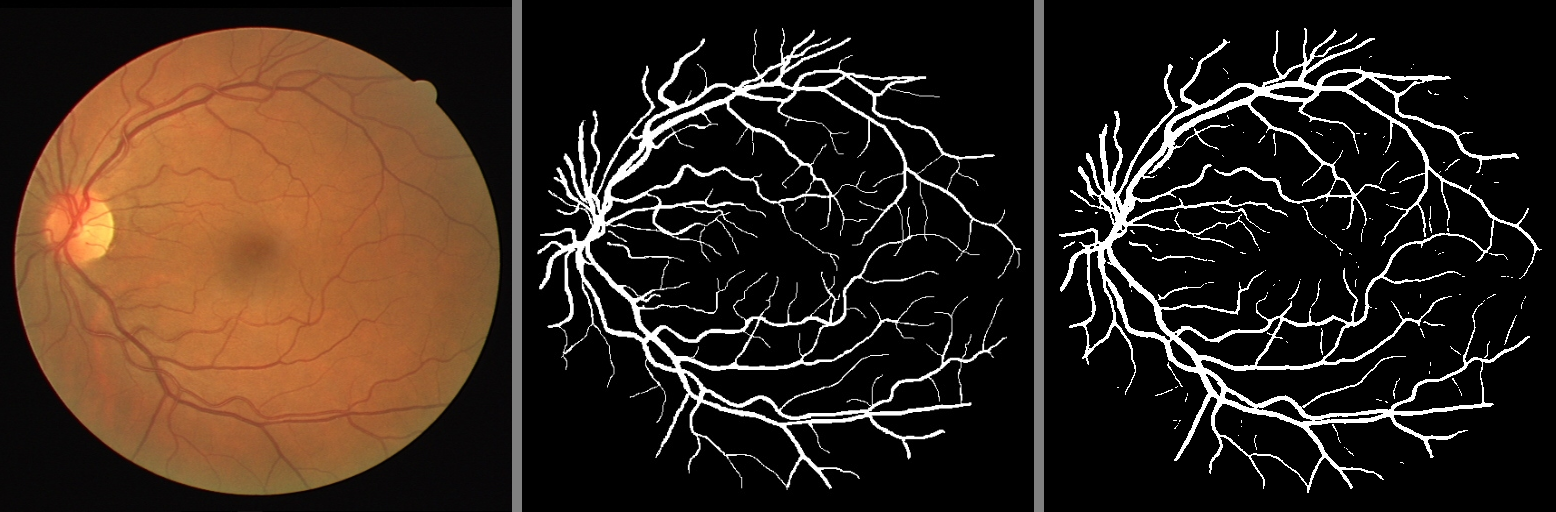

In [ ]:
  from google.colab.patches import cv2_imshow
  image = cv2.imread("/content/drive/MyDrive/SOS/DRIVE_Data/UNET/results_1/Copy of 01_test_0.png") 
  # image_2 = cv.cvtColor(image, cv.COLOR_BGR2RGB)
  cv2_imshow(image)

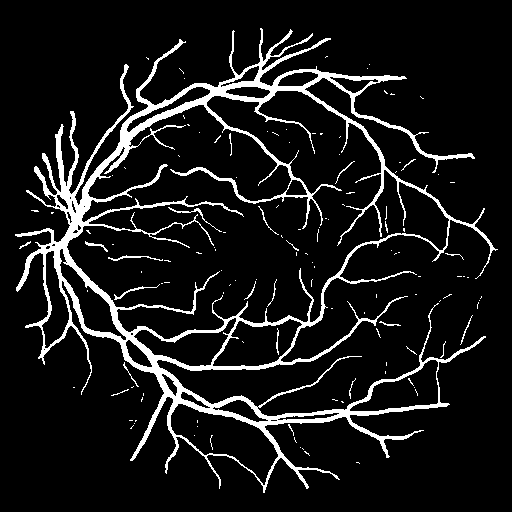

(512, 512)


In [ ]:
image1 = cv2.imread("/content/drive/MyDrive/SOS/DRIVE_Data/UNET/results_1/Trial1.png", cv2.COLOR_BGR2GRAY)
cv2_imshow(image1)

image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
print(image1.shape)

In [ ]:
kernel = np.ones((2,2),np.uint8)
closing = cv2.morphologyEx(image1, cv2.MORPH_CLOSE, kernel)


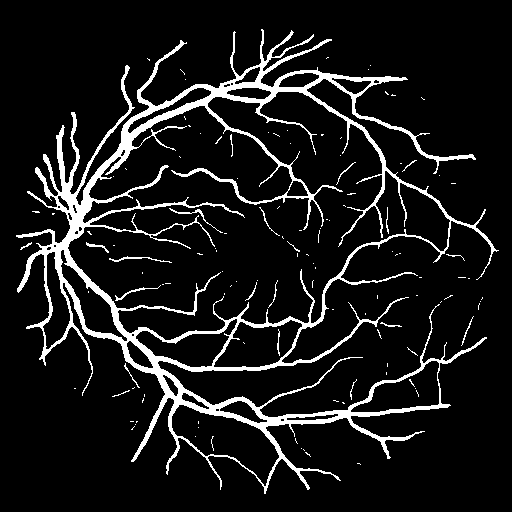

In [ ]:
cv2_imshow(closing)

In [ ]:
gray = closing
# print(np.unique(gray))
# cv2_imshow(gray)


[  0 255]


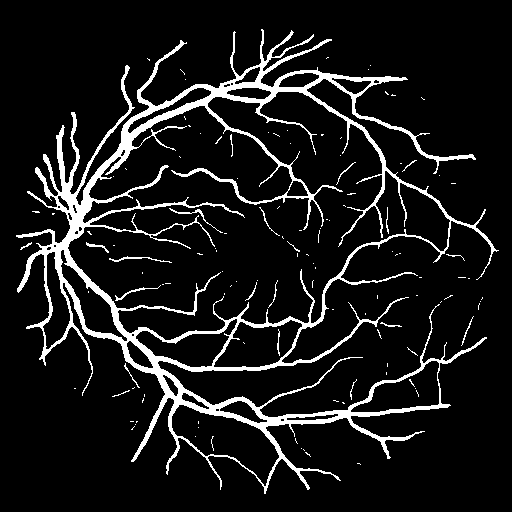

In [ ]:
# gray = gray.astype('int32')
print(np.unique(closing))
cv2_imshow(closing)


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
y_true = cv2.imread('/content/drive/MyDrive/SOS/DRIVE_Data/UNET/new_data/test/mask_1/Copy of 01_test_0.png', cv2.IMREAD_GRAYSCALE)
# score_f1 = f1_score(y_true, gray)
# score_f1
print(y_true.shape, gray.shape)

(512, 512) (512, 512)


In [ ]:
# pred_y = np.squeeze(gray, axis=0)


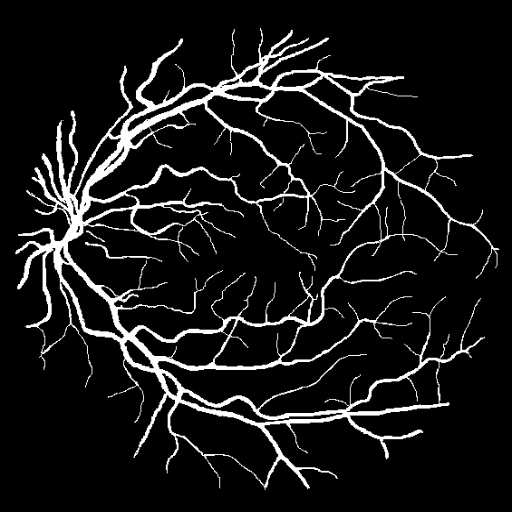

In [ ]:
cv2_imshow(y_true)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


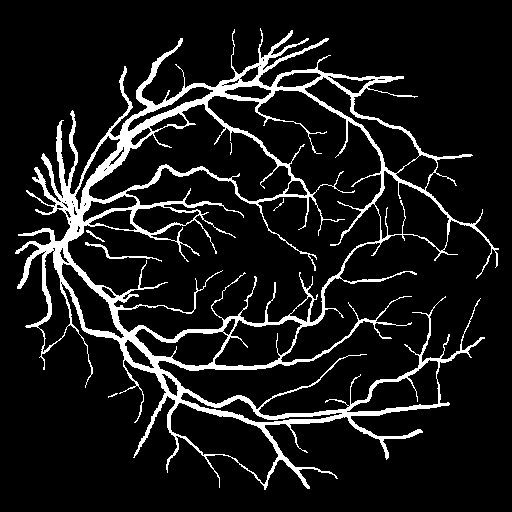

In [ ]:
for i in range(512):
  for j in range(512):
    if y_true[i][j] > 75:
      y_true[i][j] = 255
    else:
      y_true[i][j] = 0
print(y_true)
cv2_imshow(y_true)

In [ ]:
np.unique(y_true)
# y_true = y_true.astype('int32')
# pred_y = pred
print(np.unique(y_true))

[  0 255]


In [ ]:
 np.unique(image1)
#  image1 = image1.astype('int32')

array([  0, 255], dtype=uint8)

In [ ]:
# recall for true image and predicted
score_f1 = f1_score(y_true, image1, average = 'micro')
score_f1

0.8167565485362097

In [ ]:
#after 10 loops of closing:
for i in range(10):
  kernel = np.ones((3,3),np.uint8)
  closing = cv2.morphologyEx(image1, cv2.MORPH_CLOSE, kernel)

In [ ]:
score_f1 = f1_score(y_true, closing, average = 'micro')
score_f1

0.8165916471995898

In [ ]:
!pwd